# CS 7641 HW3 Code - Unsupervised Learning

This file will provide analysis clustering and dimensionality reduction techniques for for two datasets.

Datasets: Handwritten Digits, Breast Cancer

Clustering Techniques: k-Means, Expectation Maximization.
Dimensionality Reduction Techniques: PCA, ICA, RCA, RFC

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [30]:
import os
import pandas as pd
import numpy as np
import random
import gc
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Load the Handwritten Digits Data

In [31]:
## Download the Phishing Data from OpenML https://www.openml.org/d/4534

df_phish = pd.read_csv('data/optdigits.csv').astype('category')
print("Data has",len(df_phish),"rows and", len(df_phish.columns),"columns.")
if df_phish.isnull().values.any():
    print("Warning: Missing Data")
df_phish.head()
#df_phish.describe(include='all')

Data has 5620 rows and 65 columns.


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,Class
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [32]:
column_order = list(df_phish)
column_order.insert(0, column_order.pop(column_order.index('Class')))
df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front
#df_phish.describe(include='all')

In [33]:
# df_phish.to_csv("PhishingWebsitesData_preprocessed.csv")
df_phish.head()

,Class,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A55,A56,A57,A58,A59,A60,A61,A62,A63,A64
0,0,0,1,6,15,12,1,0,0,0,...,0,0,0,0,6,14,7,1,0,0
1,0,0,0,10,16,6,0,0,0,0,...,3,0,0,0,10,16,15,3,0,0
2,7,0,0,8,15,16,13,0,0,0,...,0,0,0,0,9,14,0,0,0,0
3,4,0,0,0,3,11,16,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,6,0,0,5,14,4,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


In [34]:
gc.collect()

12

We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The phishing data is ready to go! Now we move on to loading the Bank Marketing data.

### Load the Breast Cancer Data

In [99]:
## Load the Bank Marketing Data from OpenML https://www.openml.org/d/1461

df_bank = pd.read_csv('data/breastcancer.csv')
df_bank = df_bank.iloc[:,1:]
print("Data has",len(df_bank),"rows and", len(df_bank.columns),"columns.")
if df_bank.isnull().values.any():
    print("Warning: Missing Data")
df_bank.head()
#df_bank.describe(include='all')

Data has 569 rows and 31 columns.


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


This dataset needs some preprocessing love too. We will convert all categorical columns using one hot encoding. Additionally, we will standardize all of the numeric features and we will convert the target variable from {no,yes} to {0,1}. It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers. Finally we will standardize all numeric columns.

In [100]:
# col_1hot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
# df_1hot = df_bank[col_1hot]
# df_1hot = pd.get_dummies(df_1hot).astype('category')
# df_others = df_bank.drop(col_1hot,axis=1)
# df_bank = pd.concat([df_others,df_1hot],axis=1)
column_order = list(df_bank)
column_order.insert(0, column_order.pop(column_order.index('diagnosis')))
df_bank = df_bank.loc[:, column_order]
df_bank['diagnosis'].replace("M",1,inplace=True)
df_bank['diagnosis'].replace("B",0,inplace=True)
df_bank['diagnosis'] = df_bank['diagnosis'].astype('category')

# numericcols = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean', 'compactness_mean', 'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean','radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se','compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se','fractal_dimension_se', 'radius_worst', 'texture_worst','perimeter_worst', 'area_worst', 'smoothness_worst','compactness_worst', 'concavity_worst', 'concave points_worst','symmetry_worst', 'fractal_dimension_worst']
df_num = df_bank.iloc[:,1:]
df_stand =(df_num-df_num.min())/(df_num.max()-df_num.min())
# df_stand = pd.DataFrame(scale(df_bank.iloc[:,1:]))
# df_stand.columns = df_bank.iloc[:,1:].columns
# df_bank_categorical = df_bank.drop(numericcols,axis=1)
df_bank_categorical = df_bank.iloc[:,0]
df_bank = pd.concat([df_bank_categorical,df_stand],axis=1)
#df_bank.describe(include='all')

In [101]:
# df_bank.to_csv("BankMarketingData_preprocessed.csv")
df_bank.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,1,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,1,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [102]:
gc.collect()

58

Now we have successfully loaded and processed both datasets. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [106]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_phish.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_phish.values[:,0],dtype='int64')
    X2 = np.array(df_bank.values[:,1:-1],dtype='float64')
    Y2 = np.array(df_bank.values[:,0],dtype='int64')
    return X1, Y1, X2, Y2


def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)
    return pred

def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

## Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate. This will be used later when we compare neural networks built from different combinations of features after clustering and dimensionality reduction

In [65]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(accuracy_score(y_test, y_pred_test))
            f1_train.append(accuracy_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train Accuracy')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
# def NNGridSearchCV(X_train, y_train):
#     #parameters to search:
#     #number of hidden units
#     #learning_rate
#     h_units = [5, 10, 20, 30, 40, 50, 75, 100]
#     param_grid = {'hidden_layer_sizes': h_units}

#     net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',learning_rate_init=0.05,random_state=100),
#                        param_grid=param_grid, cv=10)
#     net.fit(X_train, y_train)
#     print("Per Hyperparameter tuning, best parameters are:")
#     print(net.best_params_)
#     return net.best_params_['hidden_layer_sizes']


def NNGridSearchCV(X_train, y_train, h_units, learning_rates):
    #parameters to search:
    #number of hidden units
    #learning_rate
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}

    nnet = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=10, n_jobs=-1)
    nnet.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(nnet.best_params_)
    return nnet.best_params_['hidden_layer_sizes'], nnet.best_params_['learning_rate_init']

In [66]:
gc.collect()

8

# 3. Clustering

## k-Means Clustering

This section will implement k-means clustering for both datasets. Our objectives are to:
1. Determine the best number of clusters for each dataset by using the elbow inspection method on silhouette score.
2. Describe the attributes which make up each cluster.
3. Score each cluster with an accuracy since technically we do have labels available for these datasets (labels are not used when determining clusters).

Since k-Means is susceptible to get stuck in local optima due to the random selection of initial cluster centers, I will report the average metrics over 5 models for each number of k clusters.

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, homogeneity_score #f1_score, 
import matplotlib.pyplot as plt

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,61,1))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; wcss = [];

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        wcss.append(km.inertia_)
        
        sil_scores.append(sil_score(X, km.labels_, metric = 'euclidean'))
        
        y_mode_vote = cluster_predictions(y,km.labels_)
        
#         f1_scores.append(f1_score(y, y_mode_vote))
        
        homo_scores.append(homogeneity_score(y, km.labels_))
    
    print(kclusters)
    print(sil_scores)
#     print(f1_scores)
    print(homo_scores)
    print(wcss)

    # elbow curve for Within-cluster Sum of Squares
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, wcss)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()

    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores KMeans: '+ title)
    plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kclusters, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Clusters')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores KMeans: '+ title)
#     plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    homo_score = homogeneity_score(y, km.labels_)
    silh_score = sil_score(X, km.labels_, metric = 'euclidean')
#     auc = roc_auc_score(y, y_mode_vote)
    wcss = km.inertia_
#     f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
#     precision = precision_score(y, y_mode_vote)
#     recall = recall_score(y, y_mode_vote)
#     cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("Homogeneity Score:  "+"{:.2f}".format(homo_score))
    print("Silhouette Score:  "+"{:.2f}".format(silh_score))    
    print("Within Cluster Sum of Squares:  "+"{:.2f}".format(wcss))    
#     print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
#     print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
#     plt.figure()
#     plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
#     plt.show()


##### Handwritten Digits Data

In [107]:
phishX,phishY,bankX,bankY = import_data()

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[0.1563604607056156, 0.16661536569039298, 0.17779957514098665, 0.18753293579606295, 0.1816053915534712, 0.18479723582292804, 0.18129303332295724, 0.1808434374304165, 0.18145958239901588, 0.17075718239197324, 0.1821751813337236, 0.17004585473528125, 0.16792656767285638, 0.1651684215431698, 0.16365250073885584, 0.1695670786552496, 0.15688441512981385, 0.15723718253473026, 0.1520983186224137, 0.13127323582030861, 0.13344446356341588, 0.12627741497954525, 0.12725968325060477, 0.12981277645209596, 0.14484734633679602, 0.12825616787233346, 0.1270444708969047, 0.1279089428916136, 0.12536604081962605, 0.1218146020271325, 0.12556005027887426, 0.12453769844237454, 

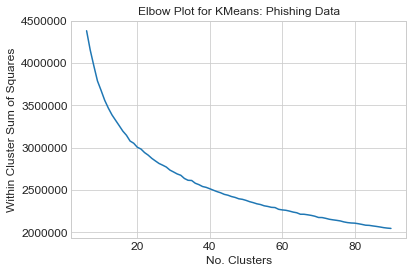

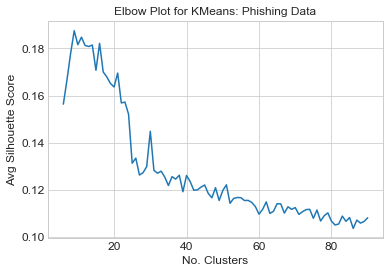

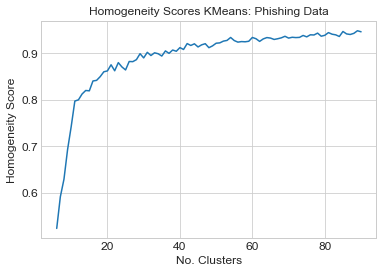

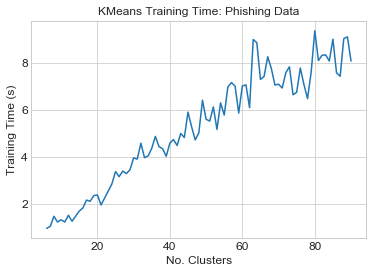

In [70]:
# phishX,phishY,bankX,bankY = import_data()
run_kmeans(phishX,phishY,'Phishing Data')

In [92]:
gc.collect()

0

In [178]:
# Run after we have optimal number of clusters
km = KMeans(n_clusters=20,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,phishX,phishY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Phishing kMeans Cluster Centers.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.25
No. Iterations to Converge: 71
Homogeneity Score:  0.86
Silhouette Score:  0.16
Within Cluster Sum of Squares:  3003318.16
Accuracy:  0.92
*****************************************************


In [108]:
gc.collect()

8887

##### Breast Cancer Data

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.1567976562757879, 0.16037056044559034, 0.15909047259060813, 0.14617650716822275, 0.14531528016806675, 0.13190366652275912, 0.14131275248325206, 0.13595379534521285, 0.11510739697082005, 0.12624210401498256, 0.12417394414687254, 0.12125019203654167, 0.11311596474178251, 0.11792543812893286, 0.11269938350296133, 0.09708508941148512, 0.10836457631453511, 0.10995641638472971, 0.10703136132272177, 0.11242774002534031, 0.09769501399828998, 0.09774510209755069, 0.10580476423709001, 0.1081622883395516, 0.09707756495096835, 0.10066575969422852, 0.1017836782670874, 0.09725586019518453, 0.10638721937135077, 0.10523147885180711, 0.10919585352888887, 0.09968952179988443, 0.09994780666121356, 0.09947407988114713, 0.09678991246241414, 0.10504381996516264, 0.09566646952750371, 0.093099

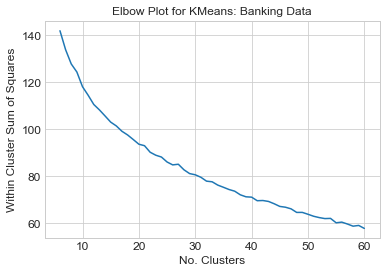

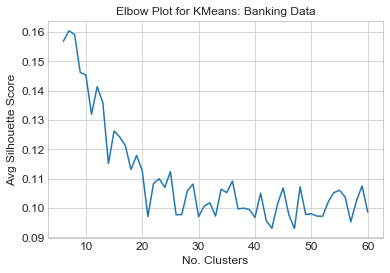

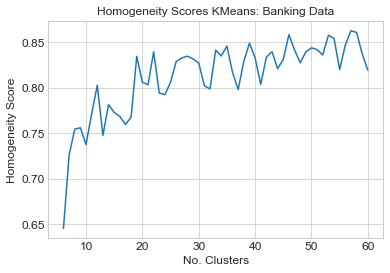

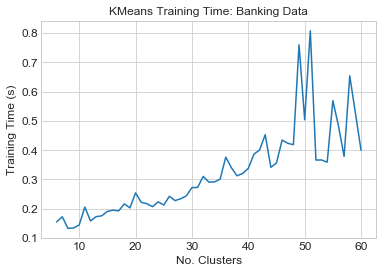

In [109]:
run_kmeans(bankX,bankY,'Banking Data')

In [110]:
gc.collect()

8777

In [111]:
km = KMeans(n_clusters=12,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,bankX,bankY)
df = pd.DataFrame(km.cluster_centers_)
df.to_csv("Banking kMeans Cluster Centers.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.20
No. Iterations to Converge: 16
Homogeneity Score:  0.80
Silhouette Score:  0.14
Within Cluster Sum of Squares:  110.62
Accuracy:  0.95
*****************************************************


In [112]:
gc.collect()

0

## Expectation Maximization

This section will implement k-means clustering for both datasets. The same 3 objectives from k-means apply here.

In [124]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,61,1))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []; logl = [];
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
#         f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        logl.append(em.score(X))

    print(kdist)
    print(sil_scores)
#     print(f1_scores)
    print(homo_scores)
    print(aic_scores)
    print(bic_scores)
    print(logl)

    # elbow curve for log likelihood
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, logl)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Log Likelihood')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores EM: '+ title)
    plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores EM: '+ title)
#     plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
#     auc = roc_auc_score(y, y_mode_vote)
    homo_score = homogeneity_score(y, labels)
    silh_score = sil_score(X, labels, metric = 'euclidean')
    aic_score = em.aic(X)
    bic_score = em.bic(X)
    logl = em.score(X)
#     f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
#     precision = precision_score(y, y_mode_vote)
#     recall = recall_score(y, y_mode_vote)
#     cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("Homogeneity Score:  "+"{:.2f}".format(homo_score))
    print("Silhouette Score:  "+"{:.2f}".format(silh_score))    
    print("AIC Score: {}".format(aic_score))
    print("BIC Score: {}".format(bic_score))
    print("Avg Log Likelihood: {}".format(logl))
#     print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
#     print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
#     plt.figure()
#     plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
#     plt.show()

In [125]:
gc.collect()

162

##### Handwritten Digits

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.05256577683898126, 0.041566945822587346, 0.05286962194501811, 0.05912803560474833, 0.11435618401066022, 0.11907675010519823, 0.11014642494509365, 0.12178525273465733, 0.11630508695307683, 0.11664390951827336, 0.09955655030457841, 0.09361370984952082, 0.10246330316030956, 0.08938404195860973, 0.08794676972258922, 0.08517297460965244, 0.07579213272632304, 0.07348636790400444, 0.08877203547066245, 0.10862201462112255, 0.10414039005477196, 0.1138763769702236, 0.11556317314619866, 0.12275628467662053, 0.12429709490198353, 0.11030328754818534, 0.06554478864982356, 0.07630358936265931, 0.08073274683168538, 0.0769204901317012, 0.07747906238805978, 0.07737381304064624, 0.05641527617339925, 0.056504823932374375, 0.04881231930403402, 0.042836843592682826, 0.07563975870

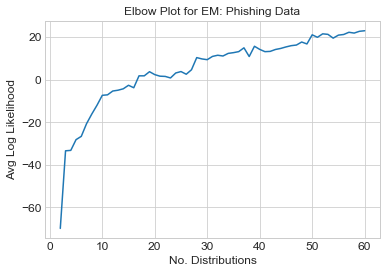

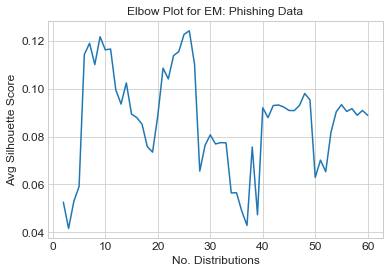

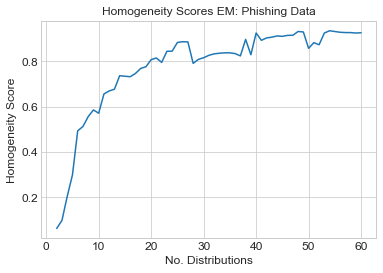

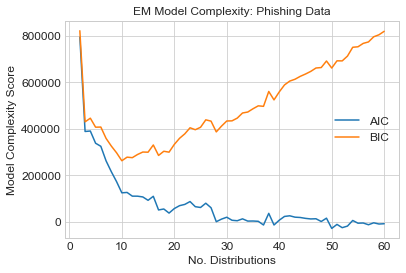

In [121]:
phishX,phishY,bankX,bankY = import_data()
run_EM(phishX,phishY,'Phishing Data')


In [122]:
gc.collect()

8910

In [179]:
em = EM(n_components=10,covariance_type='full',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,phishX,phishY)
df = pd.DataFrame(em.means_)
df.to_csv("Phishing EM Component Means.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   4.69
No. Iterations to Converge: 45
Log-likelihood Lower Bound: -7.38
Homogeneity Score:  0.57
Silhouette Score:  0.12
AIC Score: 124498.5110011978
BIC Score: 262480.88532631984
Avg Log Likelihood: -7.375490302597669
Accuracy:  0.60
*****************************************************


In [126]:
em = EM(n_components=10,covariance_type='full',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,phishX,phishY)
df = pd.DataFrame(em.xmeans_)
df.to_csv("Phishing EM Component Means.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   4.53
No. Iterations to Converge: 45
Log-likelihood Lower Bound: -7.38
Homogeneity Score:  0.57
Silhouette Score:  0.12
AIC Score: 124498.5110011978
BIC Score: 262480.88532631984
Avg Log Likelihood: -7.375490302597669
Accuracy:  0.60
*****************************************************


In [127]:
gc.collect()

0

##### Breast Cancer

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.358227569989164, 0.29660343019351226, 0.13766754592755062, 0.12275697524084313, 0.11053432044261276, 0.11847368826944425, 0.11409932365903425, 0.11448557042566092, 0.12307260814911605, 0.12855923098211114, 0.11717197763689365, 0.11424521437223684, 0.11942105905327434, 0.11678470393118828, 0.11851511701743195, 0.11396308649933236, 0.10740810857886283, 0.10638485411798153, 0.10905030536344444, 0.11010959232788099, 0.10434465311808774, 0.10765583695442704, 0.10831518422704524, 0.09993161851605634, 0.09928387256394192, 0.09941421572675682, 0.10191082323793711, 0.10367104301939066, 0.1012668322475216, 0.0976136641891674, 0.0983090207542248, 0.09746942922995874, 0.09733328389996189, 0.09912994840859851, 0.09633901525142291, 0.09737428553038921, 0.10269228413969726

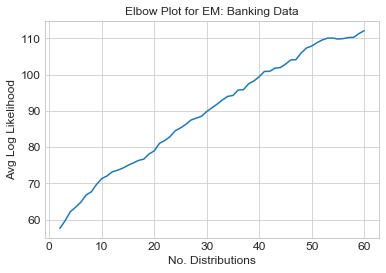

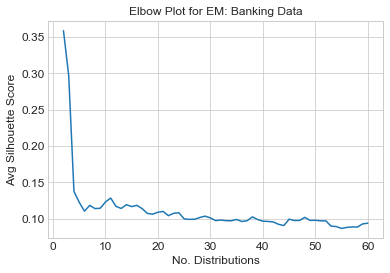

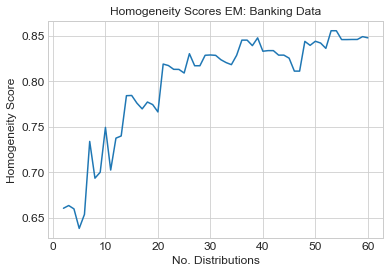

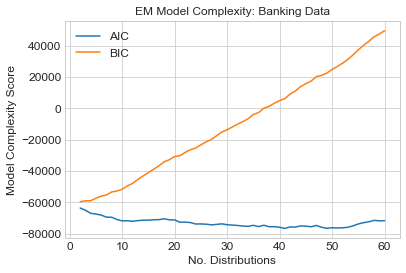

In [128]:
# phishX,phishY,bankX,bankY = import_data()
# X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.25, random_state=100)
# run_EM(X_train,y_train,'Banking Data')
run_EM(bankX,bankY,'Banking Data')


In [129]:
gc.collect()

9263

In [130]:
em = EM(n_components=10,covariance_type='full',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,bankX,bankY)
df = pd.DataFrame(em.means_)
df.to_csv("Banking EM Component Means.csv")

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.08
No. Iterations to Converge: 20
Log-likelihood Lower Bound: 71.32
Homogeneity Score:  0.75
Silhouette Score:  0.12
AIC Score: -71865.04844089218
BIC Score: -51670.348302638864
Avg Log Likelihood: 71.32078070377169
Accuracy:  0.92
*****************************************************


In [131]:
gc.collect()

0


# 4. Dimensionality Reduction

This section will implement 4 different dimensionality reduction techniques on both the phishing and the banking dataset. Then, k-means and EM clustering will be performed for each (dataset * dim_reduction) combination to see how the clustering compares with using the full datasets. The 4 dimensionality reduction techniques are:
- Principal Components Analysis (PCA). Optimal number of PC chosen by inspecting % variance explained and the eigenvalues.
- Independent Components Analysis (ICA). Optimal number of IC chosen by inspecting kurtosis.
- Random Components Analysis (RCA) (otherwise known as Randomized Projections). Optimal number of RC chosen by inspecting reconstruction error.
- Random Forest Classifier (RFC). Optimal number of components chosen by feature importance.

In [134]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=5, max_iter = 600)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[2::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

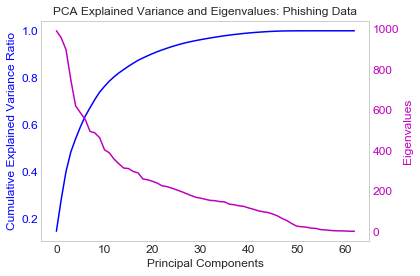

d:\miniconda3\envs\cs7641\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
d:\miniconda3\envs\cs7641\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


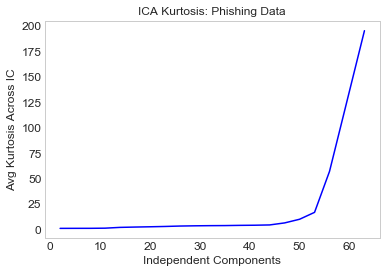

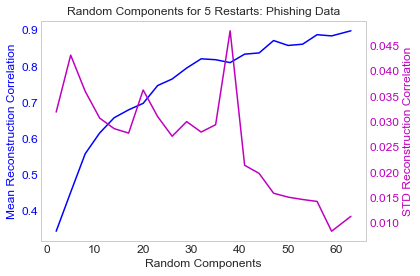

In [135]:
phishX,phishY,bankX,bankY = import_data()
run_PCA(phishX,phishY,"Phishing Data")
run_ICA(phishX,phishY,"Phishing Data")
run_RCA(phishX,phishY,"Phishing Data")
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)

##### Banking

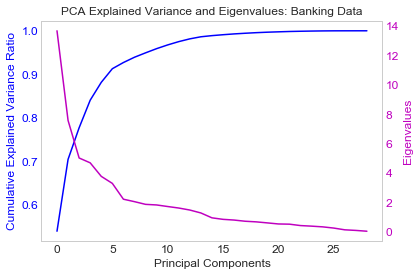

d:\miniconda3\envs\cs7641\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


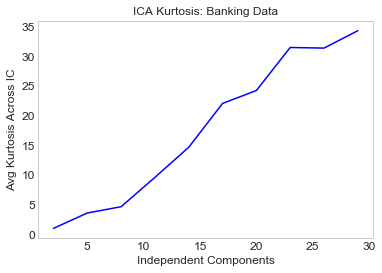

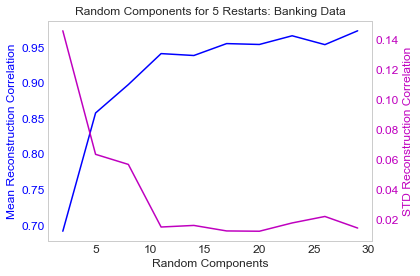

In [136]:
phishX,phishY,bankX,bankY = import_data()
# X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.2)
# run_PCA(X_train,bankY,"Banking Data")
# run_ICA(X_train,bankY,"Banking Data")
# run_RCA(X_train,bankY,"Banking Data")
# imp_bank, topcols_bank = run_RFC(X_train,y_train,df_bank)
run_PCA(bankX,bankY,"Banking Data")
run_ICA(bankX,bankY,"Banking Data")
run_RCA(bankX,bankY,"Banking Data")
imp_bank, topcols_bank = run_RFC(bankX,bankY,df_bank)

##### Recreating Clustering Experiment (k-means and EM) for phishing data.

In [140]:
phishX,phishY,bankX,bankY = import_data()
imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)
pca_phish = PCA(n_components=10,random_state=5).fit_transform(phishX)
ica_phish = ICA(n_components=10,random_state=5).fit_transform(phishX)
rca_phish = RCA(n_components=10,random_state=5).fit_transform(phishX)
rfc_phish = df_phish[topcols_phish]
rfc_phish = np.array(rfc_phish.values,dtype='int64')

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.1660610379743859, 0.16879923066119248, 0.17899767934514577, 0.20599404847884698, 0.22601438855965741, 0.23898004201816386, 0.252185485357144, 0.2668861593568824, 0.26063539745844533, 0.2648593899014036, 0.2643807148886828, 0.2657484541461857, 0.2574098183668251, 0.2514951777355117, 0.25561753016252453, 0.23548109230262754, 0.23743934628522292, 0.2386230815101084, 0.22899035326676817, 0.22234989399924385, 0.22230840964985865, 0.21928770765330322, 0.19117721339584565, 0.19687748894020732, 0.22306275755996302, 0.21204515217654102, 0.18792619290992987, 0.21057600353463643, 0.18455632920482773, 0.1825563865400124, 0.18162204251009303, 0.1828139081920284, 0.17951268844949708, 0.18017704159845851, 0.18026040972436053, 0.17763764108186203, 0.17867129110785576, 0.177

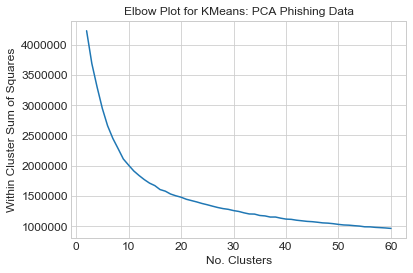

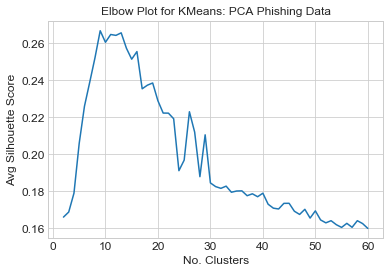

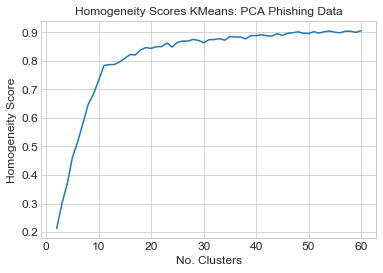

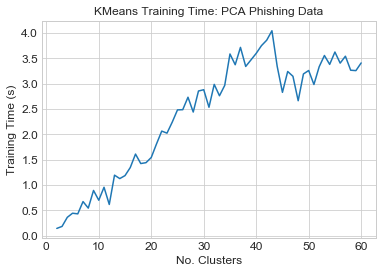

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.09400935634692144, 0.11762084230519888, 0.13684147513765385, 0.14974873817347042, 0.1660786111352393, 0.18068789665510346, 0.2020051370509572, 0.21000456829206274, 0.22464198009959982, 0.22562036616533956, 0.2334318526255148, 0.23060459143385897, 0.23173411396033436, 0.22583100778728626, 0.22024450872401516, 0.2213112144937577, 0.2192439428318641, 0.20183753837269655, 0.21479441908769806, 0.22678999907483124, 0.21907266583457033, 0.21219254208957083, 0.19664360831658148, 0.1941197364437927, 0.21422067417828022, 0.20016829910579764, 0.19185766590699593, 0.18784946998918747, 0.18742102021738494, 0.18881587549853926, 0.19013377086365515, 0.18493567179473683, 0.18564563533975056, 0.18632527289246192, 0.18572476290159154, 0.18280811389445295, 0.18429824627070004,

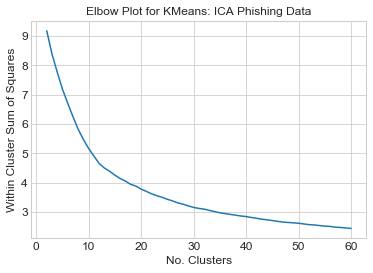

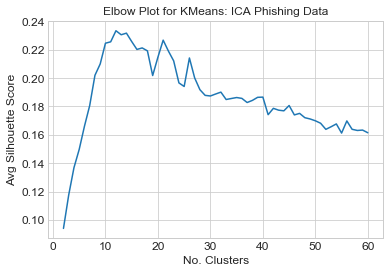

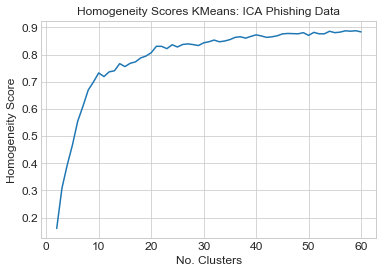

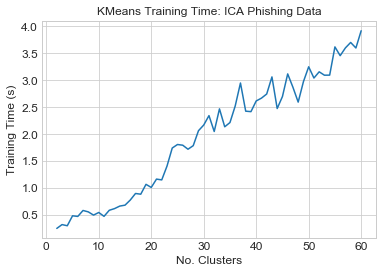

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.2241601779249802, 0.22909632083881418, 0.19586222274616016, 0.18399087369977324, 0.1771736751124285, 0.18328401011340278, 0.18214986891581128, 0.18586099012012813, 0.18596255653215615, 0.18855292725388564, 0.19029853684409917, 0.18675665968792413, 0.1850962675098776, 0.18418139780534898, 0.1836198523593987, 0.16822504295069235, 0.17755090458743264, 0.1648593340746982, 0.16211219973731128, 0.1721553607747389, 0.15805003174541007, 0.15902716443324053, 0.15771017019469644, 0.15867971138105702, 0.15413032788962372, 0.15289460463311785, 0.15343031729532444, 0.15208680773025515, 0.1527742384857301, 0.14990083181965322, 0.1480088363413887, 0.14639203913387913, 0.1476191579922432, 0.14404205828877423, 0.14362633431081745, 0.14077476833377608, 0.14482790964667266, 0.

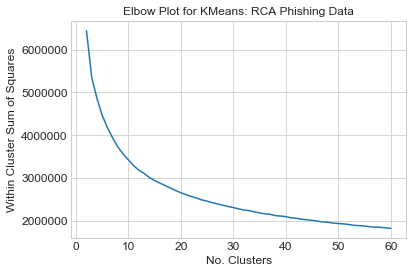

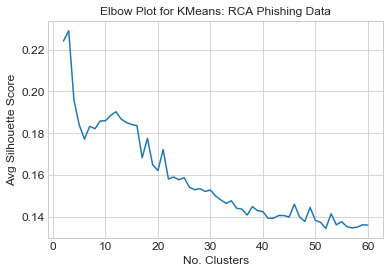

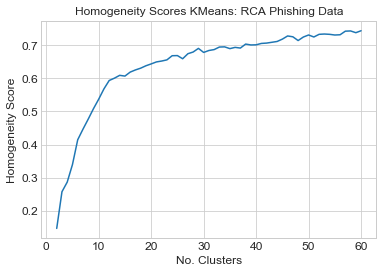

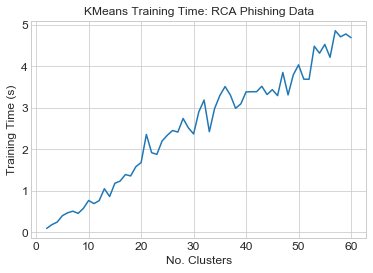

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.12283248738496737, 0.13911699894622517, 0.14266069873071197, 0.15370422356916855, 0.16876238547872888, 0.17990941231437366, 0.18998866161340508, 0.19442876412520407, 0.18782144066556716, 0.184737427056275, 0.18479849740057727, 0.18595718473917106, 0.18568809279344814, 0.1867852697982886, 0.1782224537337871, 0.17480936266152, 0.16801379910050052, 0.17371838305542198, 0.1690034470400777, 0.17300598802599004, 0.16616055147502126, 0.15044817228533358, 0.14794744235546095, 0.1437693676187629, 0.14592798562676107, 0.14362499102998, 0.14241220963618617, 0.14579336412091623, 0.14612891166398576, 0.16270797261764317, 0.1459061221811552, 0.14374456546441516, 0.14191988015747067, 0.14208479559819878, 0.14197147531594612, 0.13903850834712733, 0.13766088363490286, 0.1338

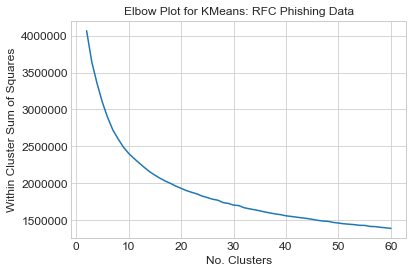

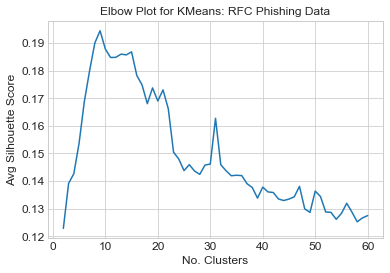

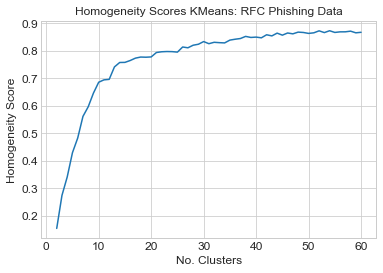

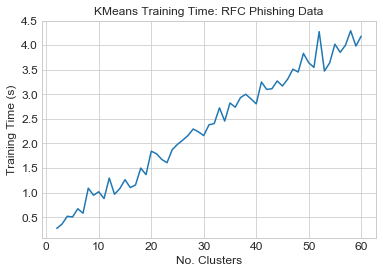

In [141]:
run_kmeans(pca_phish,phishY,'PCA Phishing Data')
run_kmeans(ica_phish,phishY,'ICA Phishing Data')
run_kmeans(rca_phish,phishY,'RCA Phishing Data')
run_kmeans(rfc_phish,phishY,'RFC Phishing Data')

In [146]:
evaluate_kmeans(KMeans(n_clusters=11,n_init=10,random_state=100,n_jobs=-1),pca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=12,n_init=10,random_state=100,n_jobs=-1),ica_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),rca_phish,phishY)
evaluate_kmeans(KMeans(n_clusters=13,n_init=10,random_state=100,n_jobs=-1),rfc_phish,phishY)

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.42
No. Iterations to Converge: 17
Homogeneity Score:  0.78
Silhouette Score:  0.26
Within Cluster Sum of Squares:  1913709.26
Accuracy:  0.86
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.42
No. Iterations to Converge: 34
Homogeneity Score:  0.74
Silhouette Score:  0.23
Within Cluster Sum of Squares:  4.65
Accuracy:  0.81
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.65
No. Iterations to Converge: 25
Homogeneity Score:  0.61
Silhouette Score:  0.19
Within Cluster Sum of Squares:  3008953.43
Accuracy:  0.73
*****************************************************
Model Evaluation Metri

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.16616173497432646, 0.1546618897200192, 0.1743886298677048, 0.16607640140695853, 0.21818161138600795, 0.2314687929745907, 0.2382885199540294, 0.25546215591636773, 0.25714912278238095, 0.25296068852926035, 0.24274869547176398, 0.2367275924729927, 0.2109486242484306, 0.20085670315146073, 0.20686259976926422, 0.21579773016620712, 0.22043235026560073, 0.22011200706435027, 0.2095802110065953, 0.18258034131901607, 0.17508162284987797, 0.17924436871197463, 0.17266751185260668, 0.1660751493055886, 0.16408231779845386, 0.1592345292620747, 0.14298377109591687, 0.13644964182624575, 0.13752326586817337, 0.14041404640672078, 0.1372017418651324, 0.13745261806048298, 0.13345983335004127, 0.13669023533660976, 0.13372364711713283, 0.12772238553371465, 0.1251538921028215, 0.12

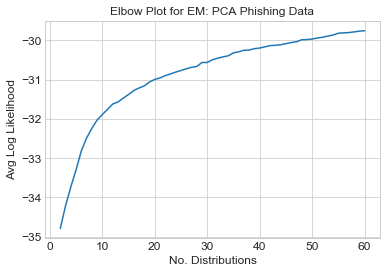

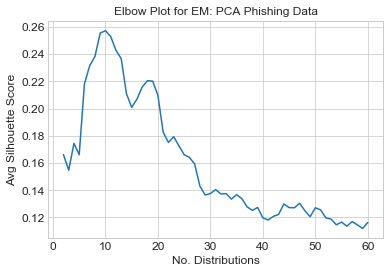

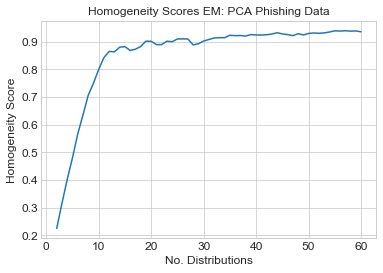

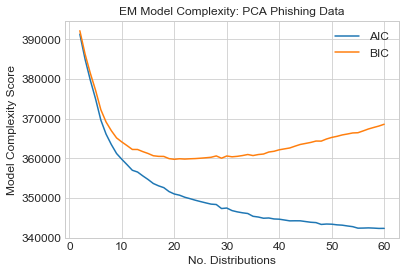

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.06971971486307492, 0.09994279755093421, 0.11865855251254968, 0.13666233609290876, 0.15003774730364094, 0.16677830562097595, 0.19016857038527318, 0.18839304610067142, 0.1973347460242418, 0.20501630040590213, 0.2123479514518287, 0.20766898358283153, 0.21726932492321152, 0.2044413756189976, 0.17942665509741237, 0.1781736962985808, 0.18062909514146763, 0.1667840637439964, 0.16331972949595566, 0.1697196777414652, 0.16161193971999452, 0.15771190918643102, 0.1560718273019898, 0.14995240071281038, 0.1554875102037787, 0.15272269277764608, 0.15766196384004572, 0.14943536520873876, 0.14224300211276544, 0.1465342584856217, 0.1443895025093001, 0.14366493325120738, 0.14459308193366024, 0.1396062549041248, 0.13614862818057222, 0.13509038498038348, 0.1355027745376859, 0.130

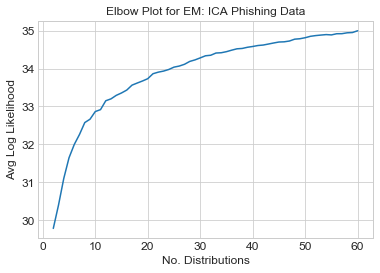

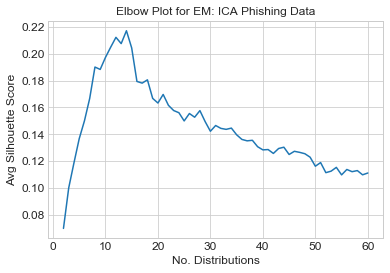

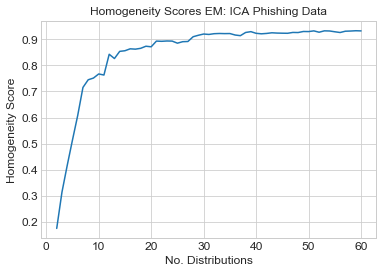

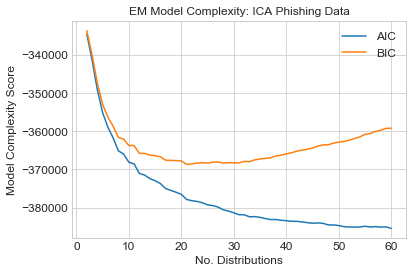

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.16991349681354953, 0.20245276284651717, 0.1710402408384162, 0.1667333230170181, 0.13458100908196222, 0.10267530070673202, 0.14104905386431948, 0.12410869573280546, 0.14518784097478624, 0.12451356573609809, 0.12823134396462457, 0.12951177384306833, 0.12598156170281127, 0.13257247883133538, 0.12300051198695676, 0.11895844465219346, 0.11354470271156002, 0.1207544363434336, 0.11513727753892897, 0.10813985803842094, 0.09961051214685963, 0.09769518960470452, 0.09137119993977186, 0.08829367404289806, 0.08248390308481715, 0.07806413881638463, 0.08254522821393526, 0.08144647123950711, 0.08105582809472464, 0.07514697758313316, 0.08232167892245612, 0.07855329438943631, 0.07514510886438273, 0.07330205593530019, 0.07601455676961608, 0.06954767572773485, 0.070024664630781

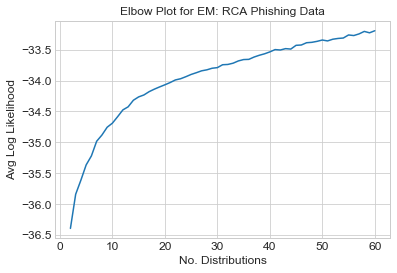

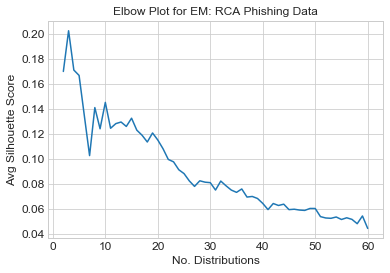

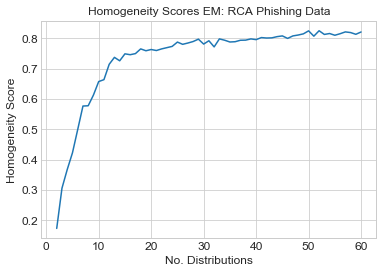

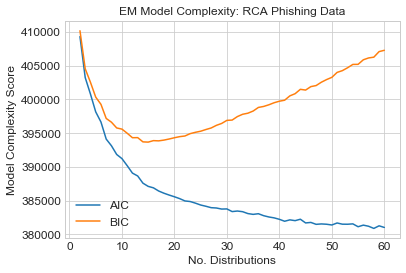

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.08456130772482705, 0.061775692981034705, 0.059619257590613275, 0.07574341789210884, 0.07461752633761719, 0.09305496037937301, 0.08634990339908649, 0.07493365843523274, 0.10867394304315547, 0.0179820555886697, 0.09852641072236802, 0.08948332911207568, 0.07388111435375067, 0.08932276293872082, 0.05695906632092984, 0.08336136440933051, 0.08246593973678848, 0.07580383009736977, 0.06556406520567541, 0.0439627386961194, 0.047396253667078295, 0.05751583713811955, 0.04937952938651883, 0.05868495399583268, 0.060201738693811575, 0.04563602738151952, 0.059271384926065596, 0.05031958471324507, 0.0441796964317266, 0.038723332698244864, 0.04107564336782542, 0.050336355960256596, 0.044076195360497304, 0.04336241204170542, 0.025474460836169745, 0.043269724342823584, 0.04000

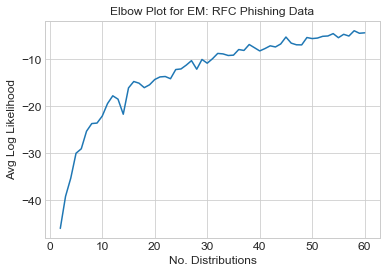

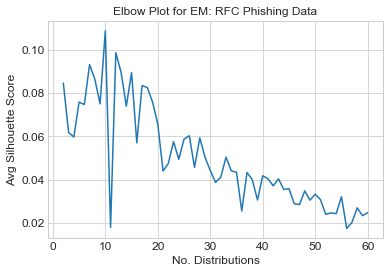

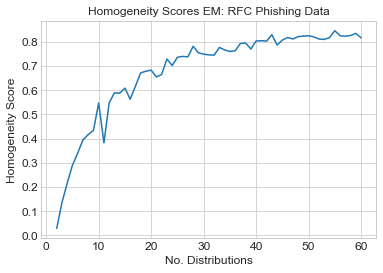

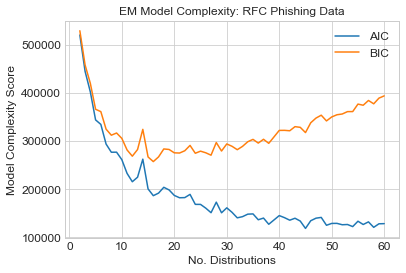

In [147]:
run_EM(pca_phish,phishY,'PCA Phishing Data')
run_EM(ica_phish,phishY,'ICA Phishing Data')
run_EM(rca_phish,phishY,'RCA Phishing Data')
run_EM(rfc_phish,phishY,'RFC Phishing Data')

In [149]:
evaluate_EM(EM(n_components=11,covariance_type='full',n_init=1,warm_start=True,random_state=100),pca_phish,phishY)
evaluate_EM(EM(n_components=13,covariance_type='full',n_init=1,warm_start=True,random_state=100),ica_phish,phishY)
evaluate_EM(EM(n_components=12,covariance_type='full',n_init=1,warm_start=True,random_state=100),rca_phish,phishY)
evaluate_EM(EM(n_components=19,covariance_type='full',n_init=1,warm_start=True,random_state=100),rfc_phish,phishY)

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.20
No. Iterations to Converge: 11
Log-likelihood Lower Bound: -31.76
Homogeneity Score:  0.84
Silhouette Score:  0.25
AIC Score: 358384.0061668483
BIC Score: 363193.7192004419
Avg Log Likelihood: -31.755694498829918
Accuracy:  0.89
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.31
No. Iterations to Converge: 31
Log-likelihood Lower Bound: 33.20
Homogeneity Score:  0.83
Silhouette Score:  0.21
AIC Score: -371468.68777992664
BIC Score: -365783.27526987187
Avg Log Likelihood: 33.20130674198636
Accuracy:  0.86
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.28
No. Iterations to Converge: 

##### Recreating Clustering Experiment (k-means and EM) for banking data.

In [155]:
pca_bank = PCA(n_components=4,random_state=5).fit_transform(bankX)
ica_bank = ICA(n_components=5,random_state=5).fit_transform(bankX)
rca_bank = RCA(n_components=6,random_state=5).fit_transform(bankX)
rfc_bank = df_bank[topcols_bank]
rfc_bank = np.array(rfc_bank.values,dtype='float64')

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.44841179489549515, 0.3878720678656152, 0.37873249716240476, 0.21893315242840553, 0.21311904664818207, 0.22660496443004993, 0.22284888877557962, 0.20959528125929586, 0.19711050621357915, 0.20837542614473506, 0.20052365947128997, 0.19578111278330337, 0.18462048270605225, 0.19193256445551102, 0.19215895837856153, 0.2018869352622633, 0.19649807862577434, 0.1962672921947298, 0.19728689082112547, 0.20212198446407928, 0.20368268441689458, 0.19779143315978917, 0.19502187777163532, 0.19552683521902087, 0.20014048943804952, 0.20297430792685486, 0.2059430635855309, 0.20030639254739432, 0.19371062132968553, 0.20162276010807736, 0.19588950484540152, 0.19009086191995547, 0.1921633181472042, 0.18703849740422798, 0.1959367699201567, 0.19069619657429687, 0.195230061619282, 0

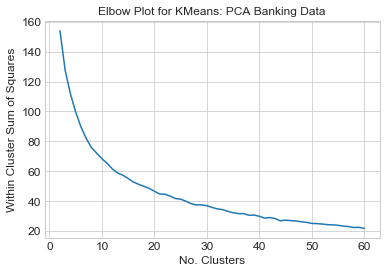

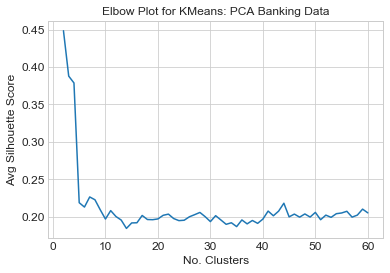

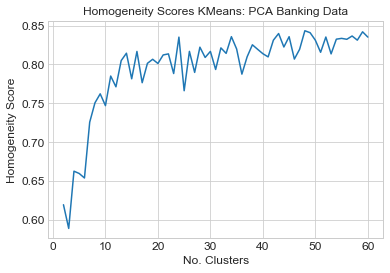

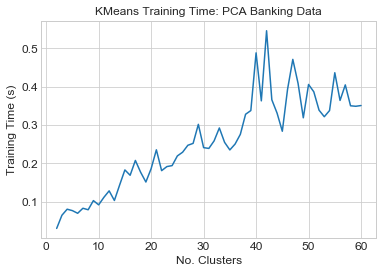

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.20638707383317068, 0.21841108990940494, 0.1894291128646753, 0.20334569361252744, 0.20787305954773144, 0.20629427485494814, 0.1764369980728113, 0.16981237034791316, 0.17673989557035893, 0.15912946734379818, 0.16453596851661248, 0.17038277799541254, 0.16655269599104153, 0.175321652367958, 0.16887791212602937, 0.15492006976825348, 0.16834997152977038, 0.17172638243200478, 0.17284406028765525, 0.16775151226140012, 0.1645002521329293, 0.16153812559392466, 0.17074872015128809, 0.1647604569706413, 0.1563339272466324, 0.17202979705014426, 0.16526772447785015, 0.16706990287060408, 0.16761431820830272, 0.17043867010626135, 0.17173514868081047, 0.1655480077856059, 0.16972884784024225, 0.1677432527281154, 0.16648355330565318, 0.1644229496372458, 0.16421593578138172, 0.1

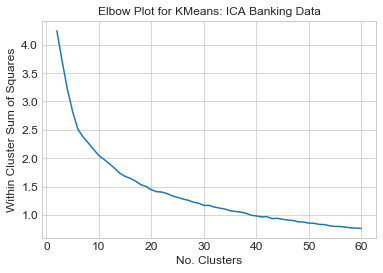

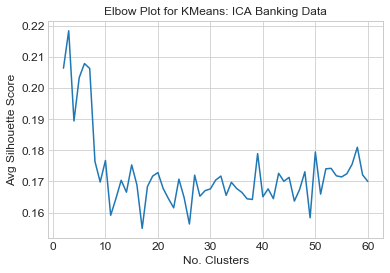

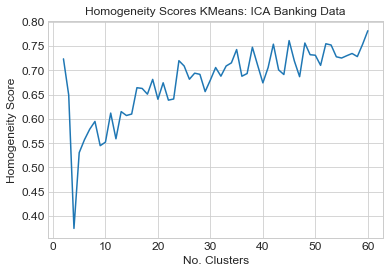

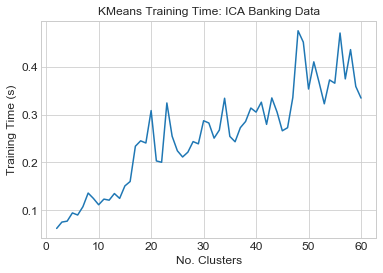

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.2676699667651471, 0.2579944037441053, 0.25214465417532517, 0.23811984290501062, 0.23248851174522675, 0.22818120135138104, 0.19553914363623073, 0.19880995657116995, 0.19629951006880514, 0.19400877611060818, 0.19924518977125233, 0.20112210249329698, 0.19544376299244884, 0.1861225179739358, 0.19320420166996646, 0.18715898054459423, 0.18204181370720707, 0.17311382541898584, 0.17660560510449874, 0.17624817089521772, 0.17630821688738618, 0.16430144722824178, 0.17132249190613583, 0.17431285775961733, 0.17438332158724418, 0.17898758193905737, 0.16610871691382095, 0.172107625430165, 0.17540675712782366, 0.17835394421570985, 0.17400771296715173, 0.1663134046640533, 0.1693574939177656, 0.1746954500101728, 0.1727622612560477, 0.16950103426776988, 0.17236360312995816, 0.

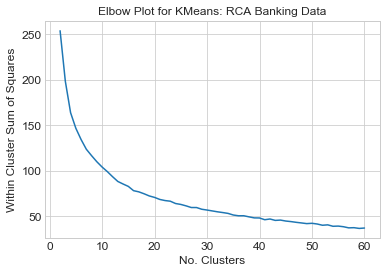

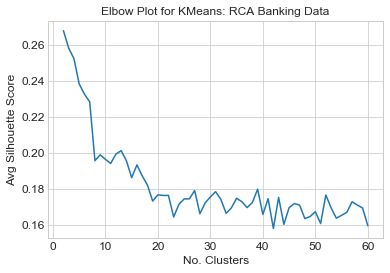

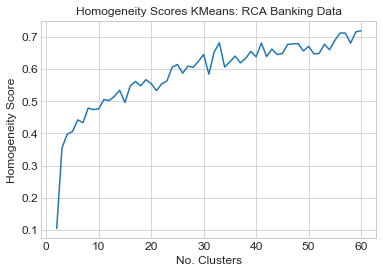

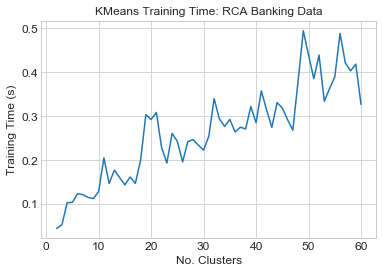

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.4184664610479809, 0.2931057565988225, 0.16807058706660297, 0.17457332569913908, 0.18021041528848492, 0.17963870907354343, 0.16997933180910035, 0.14581444866265714, 0.15292793783169134, 0.12975717721836796, 0.14164105775548944, 0.15442305472945766, 0.12853588945340177, 0.148030618933653, 0.12975152875236637, 0.13471164674300998, 0.13325281589550161, 0.1332319503888439, 0.1321765196639169, 0.13579591083802986, 0.13451443699463625, 0.13747795288366596, 0.12831768779609473, 0.13064803917306342, 0.1278005943129781, 0.1317225232263454, 0.12802109755670454, 0.12951051294743135, 0.1328684613755643, 0.12455076625096649, 0.12632648961133025, 0.12900881690155866, 0.12711167284426605, 0.1250364045061677, 0.1253058280474781, 0.1285618966024901, 0.12150339877742983, 0.123

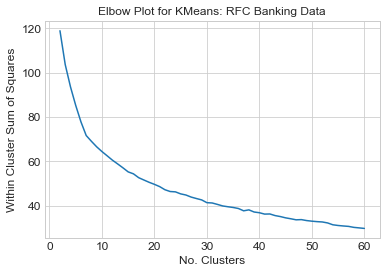

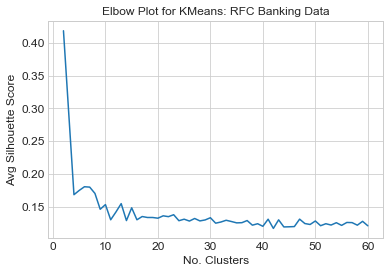

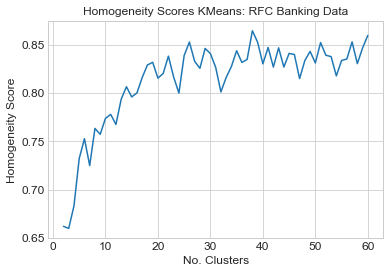

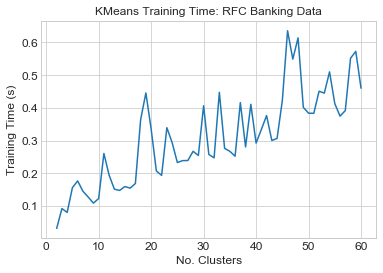

In [156]:
run_kmeans(pca_bank,bankY,'PCA Banking Data')
run_kmeans(ica_bank,bankY,'ICA Banking Data')
run_kmeans(rca_bank,bankY,'RCA Banking Data')
run_kmeans(rfc_bank,bankY,'RFC Banking Data')

In [157]:
evaluate_kmeans(KMeans(n_clusters=13,n_init=10,random_state=100,n_jobs=-1),pca_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),ica_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=13,n_init=10,random_state=100,n_jobs=-1),rca_bank,bankY)
evaluate_kmeans(KMeans(n_clusters=19,n_init=10,random_state=100,n_jobs=-1),rfc_bank,bankY)

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.14
No. Iterations to Converge: 13
Homogeneity Score:  0.80
Silhouette Score:  0.20
Within Cluster Sum of Squares:  58.83
Accuracy:  0.95
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.19
No. Iterations to Converge: 12
Homogeneity Score:  0.61
Silhouette Score:  0.17
Within Cluster Sum of Squares:  1.73
Accuracy:  0.90
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.23
No. Iterations to Converge: 48
Homogeneity Score:  0.52
Silhouette Score:  0.20
Within Cluster Sum of Squares:  88.42
Accuracy:  0.85
*****************************************************
Model Evaluation Metrics Using M

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.3824265603875317, 0.33386792537608156, 0.2369726322132135, 0.1416914729298384, 0.18577352215451473, 0.15928716468690696, 0.15453487457259674, 0.12658622172999265, 0.1200931635160145, 0.08801627177609748, 0.12100890793922914, 0.08928149877933572, 0.10715712198436514, 0.07176368003911691, 0.07230496964665659, 0.07732531121801052, 0.08555802722493705, 0.0902686294961735, 0.09779094856886535, 0.10132802473098386, 0.07772749502614926, 0.03987182670394203, 0.06626413214282939, 0.05919528633368584, 0.06990855438888376, 0.06341244996497583, 0.05455004997265614, 0.06109369651443695, 0.0603042313674868, 0.08119717667305212, 0.07225137669946707, 0.07510157847468239, 0.07571699566553718, 0.0808520846158186, 0.10749773400467132, 0.1092474739753949, 0.07059405693031746, 0

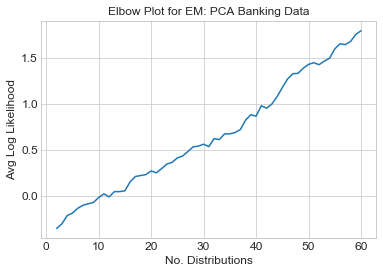

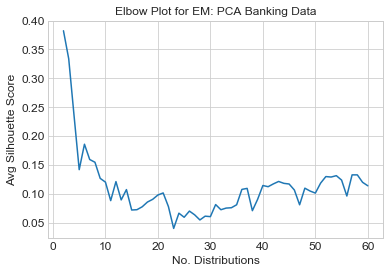

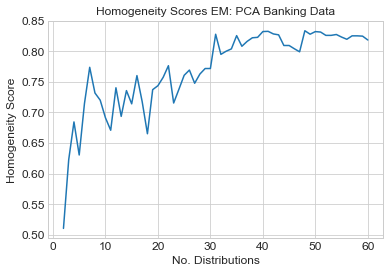

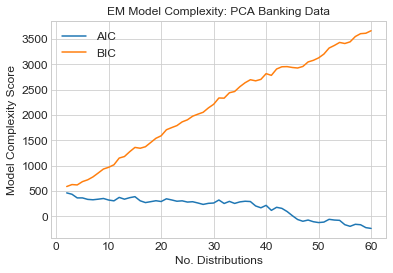

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.15074145391823995, 0.1617020042545526, 0.09805906216700833, 0.11332851201913635, 0.10948772830605423, 0.0947135843963616, 0.10854880094787313, 0.07569699267332024, 0.0685499215911238, 0.07088960376106423, 0.07733577129516205, 0.07171192530265649, 0.06551786560655491, 0.08792337789962267, 0.08082067925204188, 0.06739585676724877, 0.05291374654176168, 0.07999391757811619, 0.0906285675276771, 0.08901630660458182, 0.07283494917238217, 0.08657891254051192, 0.06741972706617602, 0.052867584838648195, 0.05175387268169091, 0.07910437276342591, 0.08396283592365009, 0.09349821825591424, 0.07173375122090671, 0.05180403451183795, 0.0631432940003397, 0.08029877470216036, 0.07213095674158058, 0.07089048914093625, 0.0874966446041995, 0.09416714300009082, 0.0885894044585396,

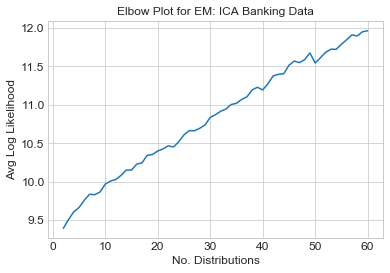

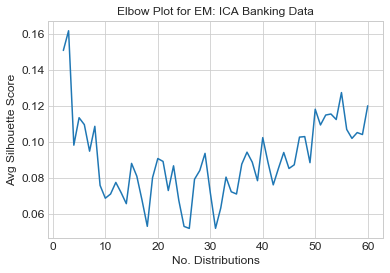

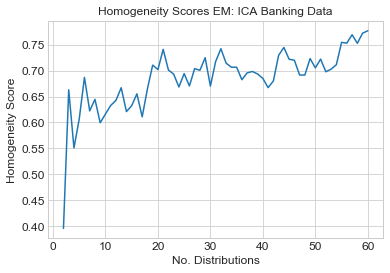

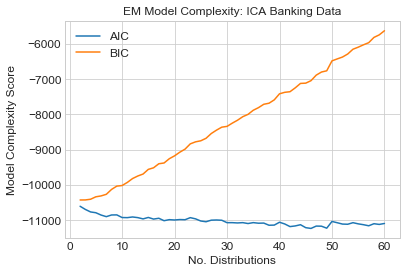

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.2145711816302532, 0.21786718636512026, 0.07448739044325664, 0.033044075071887745, 0.04131586483736851, 0.08572109247745736, 0.06699435856963042, 0.1239887772776122, 0.10592556193863026, 0.036670360470635224, 0.04747002437102259, 0.08856007251241177, 0.016473688775920967, 0.032333797658098594, 0.07574128304855288, 0.07333111704792535, 0.0783203235770626, 0.07105796682325828, 0.04069683350778039, 0.10970984429589985, 0.05036288848632788, 0.08476673582509793, 0.06099413203369598, 0.047900892709203294, 0.05152982861339023, 0.07853747514229169, 0.02844608552855436, 0.045981735696278295, 0.0402998381435111, 0.09465673648572147, 0.04823258687133039, 0.07420515814993307, 0.0977905493433089, 0.07151485765069983, 0.06765157783017113, 0.05292289314422178, 0.10283703409

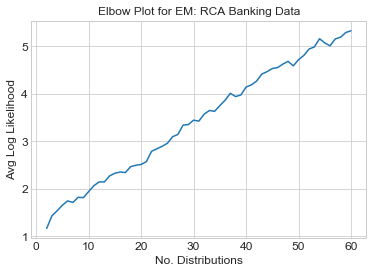

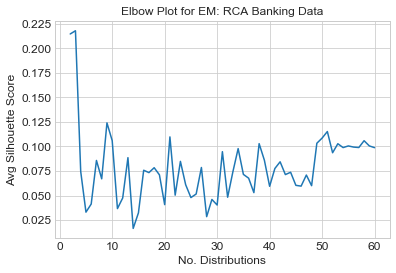

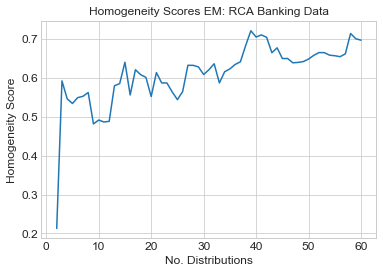

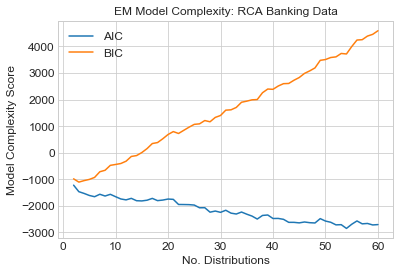

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[0.36786092690672173, 0.12561069399334115, 0.10443823814624482, 0.10071023924341349, 0.07299005686261684, 0.09066655229272233, 0.10034464929532809, 0.08069642978742948, 0.07425538913064071, 0.07331398729827926, 0.07417073664016763, 0.08310754625435224, 0.0978313660434651, 0.09878614848774124, 0.07796899799104626, 0.10149582406970753, 0.09261771084047062, 0.09208413271310624, 0.09442891199076742, 0.10416156630949157, 0.10809346934641395, 0.10193010849682961, 0.10044038011013239, 0.1061168056895119, 0.11827182770748797, 0.1138241971268316, 0.11405471910618357, 0.11539990038197177, 0.1212763846746278, 0.11492897639686486, 0.12042985598114717, 0.11788151617233136, 0.1258951828889752, 0.11716804017532732, 0.11821445298939821, 0.11834661939823772, 0.11688872542844607

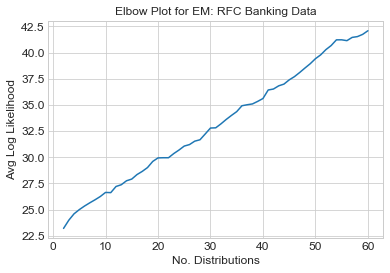

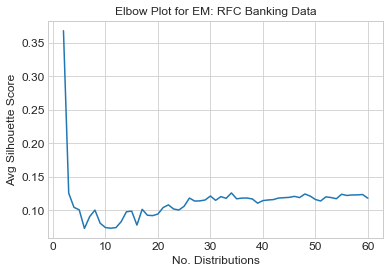

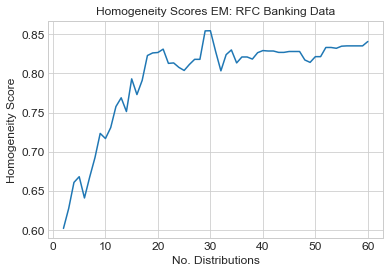

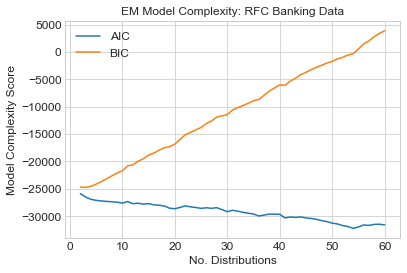

In [158]:
run_EM(pca_bank,bankY,'PCA Banking Data')
run_EM(ica_bank,bankY,'ICA Banking Data')
run_EM(rca_bank,bankY,'RCA Banking Data')
run_EM(rfc_bank,bankY,'RFC Banking Data')

In [159]:
evaluate_EM(EM(n_components=7,covariance_type='full',n_init=1,warm_start=True,random_state=100),pca_bank,bankY)
evaluate_EM(EM(n_components=6,covariance_type='full',n_init=1,warm_start=True,random_state=100),ica_bank,bankY)
evaluate_EM(EM(n_components=15,covariance_type='full',n_init=1,warm_start=True,random_state=100),rca_bank,bankY)
evaluate_EM(EM(n_components=20,covariance_type='full',n_init=1,warm_start=True,random_state=100),rfc_bank,bankY)

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.07
No. Iterations to Converge: 24
Log-likelihood Lower Bound: -0.10
Homogeneity Score:  0.77
Silhouette Score:  0.16
AIC Score: 324.1815860105615
BIC Score: 775.9451511596999
Avg Log Likelihood: -0.10209278208309444
Accuracy:  0.95
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.05
No. Iterations to Converge: 33
Log-likelihood Lower Bound: 9.76
Homogeneity Score:  0.69
Silhouette Score:  0.11
AIC Score: -10854.80004381724
BIC Score: -10311.814989551449
Avg Log Likelihood: 9.758172270489666
Accuracy:  0.93
*****************************************************
Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.12
No. Iterations to Converge: 40